In [1]:
import h5py
import re
#import hickle as hkl
import torch
import torch.nn as nn
from torch.legacy.nn import Reshape
import graphviz
import torch.nn.functional as F
from torch.autograd import Variable
#from visualize import make_dot
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread, imshow
import time
import logging
from math import log,sqrt

/home/cvrlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
incep_v3 = models.inception_v3(pretrained=True)

In [ ]:
print(incep_v3)

In [ ]:
#incep_v3.AuxLogits
list(incep_v3.children())[14:17]

#list(incep_v3.children())[0:3]

In [3]:
def InitializeWeights(mod):
    for m in mod.modules():
        if isinstance(m,nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            #print m.weight.size(), m.out_channels, m.in_channels
            m.weight.data.normal_(0,sqrt(2./n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.bias.data.zero_()
    return mod

In [4]:
conv1_l = nn.Sequential(nn.BatchNorm2d(2048),nn.ReLU(),nn.Conv2d(2048,1024,1))
conv1_l = InitializeWeights(conv1_l)
conv2_l = nn.Sequential(nn.BatchNorm2d(1024),nn.ReLU(),nn.Conv2d(1024,512,(2,2),(1,2)))
conv2_l = InitializeWeights(conv2_l)
conv3_l = nn.Sequential(nn.BatchNorm2d(512),nn.ReLU(),nn.Conv2d(512,128,(3,3)))
conv3_l = InitializeWeights(conv3_l)
norm1_l = nn.BatchNorm2d(128)
norm1_l = InitializeWeights(norm1_l)
fc1_l = nn.Sequential(nn.Linear(256, 1))
fc1_l = InitializeWeights(fc1_l)
#############__________Aux_____________#############
conv1_aux = nn.Sequential(nn.BatchNorm2d(768),nn.ReLU(),nn.Conv2d(768,128,4,(1,2),(1,0)))
conv1_aux = InitializeWeights(conv1_aux)
conv2_aux = nn.Sequential(nn.BatchNorm2d(128),nn.ReLU(),nn.Conv2d(128,32,(1,2)))
conv2_aux = InitializeWeights(conv2_aux)
norm1_aux = nn.BatchNorm2d(32)
norm1_aux = InitializeWeights(norm1_aux)
fc1_aux = nn.Sequential(nn.Linear(640, 1))
fc1_aux = InitializeWeights(fc1_aux)

In [5]:
class IV3_git(nn.Module):
    def __init__(self, pretrained_model):
        super(IV3_git, self).__init__()
        self.layer0_2 = nn.Sequential(*list(incep_v3.children())[0:3])#[0,1,2]
        self.layer3_4 =  nn.Sequential(*list(incep_v3.children())[3:5])#[3,4]
        self.layer5_12 =  nn.Sequential(*list(incep_v3.children())[5:13])#[5,12]
        self.layer14_16 =  nn.Sequential(*list(incep_v3.children())[14:17])#[14,6]
        ############
        self.aauxLogits = nn.Sequential(*list(incep_v3.AuxLogits.children())[:-1])
        #######################
        self.conv1_l = conv1_l
        self.conv2_l = conv2_l
        self.conv3_l = conv3_l
        self.norm1_l = norm1_l
        self.fc1_l = fc1_l
        ########################   
        self.conv1_aux = conv1_aux
        self.conv2_aux = conv2_aux
        #self.conv3_aux = conv3_aux
        self.norm1_aux = norm1_aux
        self.fc1_aux= fc1_aux
        
        
            
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        
            
    def forward(self, x):
        y1 = self.layer0_2(x)
        y1 = F.max_pool2d(y1, kernel_size=3, stride=2)
        y1 = self.layer3_4(y1)
        y1 = F.max_pool2d(y1, kernel_size=3, stride=2)
        y1 = self.layer5_12(y1)
        #################
        #if self.aux_logits:
        aux = self.aauxLogits(y1)
        aux = self.conv1_aux(aux)
        aux = self.conv2_aux(aux)
        #aux = self.conv3_aux(aux)
        aux = self.norm1_aux(aux)
        aux = aux.view(-1, self.num_flat_features(aux))
        aux = self.fc1_aux(aux)
        ##################
        y1 = self.layer14_16(y1)
        #y1 = F.avg_pool2d(y1, kernel_size=8)
        y1 = F.dropout(y1)
        y1 = self.conv1_l(y1)
        y1 = self.conv2_l(y1)
        y1 = self.conv3_l(y1)
        y1 = self.norm1_l(y1)
        y1 = y1.view(-1, self.num_flat_features(y1))
        y1= self.fc1_l(y1)
        ##################
        
        return aux,y1


In [6]:
net = IV3_git(incep_v3)


In [ ]:
print(net)

In [7]:
input1=Variable(torch.Tensor(10,3,180,320))
tic=time.time()
aux,incep=net(input1)
tac=time.time()
print("aux\t "+str(aux.size()))
print("incep\t "+str(incep.size()))
print(tac-tic)

aux	 torch.Size([10, 1])
incep	 torch.Size([10, 1])
1.9405953884124756


In [ ]:
print(incep)
print(aux)

In [ ]:
sum1 = 0
        
print("Number of layers ---> ",len(list(incep_v3.parameters())))
for params in incep_v3.parameters():
    if params.requires_grad == True:
        sum1 += params.numel()
    
print("Total number of parameters ---> ",sum1)

In [ ]:
sum1 = 0
        
print("Number of layers ---> ",len(list(net.parameters())))
for params in net.parameters():
    if params.requires_grad == True:
        sum1 += params.numel()
    
print("Total number of parameters ---> ",sum1)

In [ ]:
# #############      rough
# ind1 = np.random.randint(0,24)
# print(ind1)

In [8]:
tic_1=time.time()
file = h5py.File('./DATASET/CODE/NewTrainData_59_cor__35000.h5')
xtrainT = torch.from_numpy(np.array(file['xtrain'],dtype=np.float32)).float()
ytrainT = torch.from_numpy(np.array(file['ytrain'],dtype=np.float32)).float()
#xtrain = np.array(file['xtrain'],dtype=np.float32)
#ytrain = np.array(file['ytrain'],dtype=np.float32)
toc_1=time.time()
print(toc_1-tic_1)

184.92919445037842


In [51]:
file = h5py.File('./DATASET/CODE/NewTestData_22_cor_random.h5')
xtestT = torch.from_numpy(np.array(file['xtest'],dtype=np.float32)).float()
ytestT = torch.from_numpy(np.array(file['ytest'],dtype=np.float32)).float()
#xtest = np.array(file['xtest'],dtype=np.float32)
#ytest = np.array(file['ytest'],dtype=np.float32)

In [52]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [53]:
#xtrainT = batch_rgb_to_bgr(xtrainT)
xtestT = batch_rgb_to_bgr(xtestT)
#print(xtrainT.size(), xtestT.size())
#print(xtrainT.size())

In [54]:
#xtrainT = torch.div(xtrainT,255.0)
xtestT = torch.div(xtestT,255.0)

In [ ]:
# denom = [255.0,255.0,255.0]
# for t, m in zip(xtrainT, denom):
#          t.div_(m)

In [ ]:
print(xtrainT.size(), ytrainT.size(), xtestT.size(), ytestT.size())

In [24]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [55]:
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
#xtrainT = norm(xtrainT)
xtestT = norm(xtestT)

In [ ]:
#print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))
print(torch.min(xtrainT), torch.max(xtrainT))

In [ ]:
print(xtrainT[1,0,0,0])
type(xtrainT)
#xtrainT.index(255.0)

In [12]:
def train(model, loss, optimizer, x_val, y_ang,y_dis,batch_size):
    x = Variable(x_val,requires_grad = False).cuda()
    y1 = Variable(y_ang,requires_grad = False).cuda()
    y2 = Variable(y_dis,requires_grad = False).cuda()
    
    optimizer.zero_grad()
    x = batch_rgb_to_bgr(x)
    x = torch.div(x,255.0)
    mn = [0.406,0.456,0.485]
    sd = [0.225,0.224,0.229]
    x[:,0,:,:] = (x[:,0,:,:]-mn[0])/sd[0]
    x[:,1,:,:] = (x[:,1,:,:]-mn[1])/sd[1]
    x[:,2,:,:] = (x[:,2,:,:]-mn[2])/sd[2]
    #x=torch.div(torch.sub(x-mn),sd)
    
    fx1,fx2 = model.forward(x)
    
    #print fx.data[0][0][64][87]
    #fx = model5.forward(Variable(xtest2[start:end], volatile=True).cuda())
    ##output = loss.forward(fx,y,validPixel,batch_sz)
    output = loss.forward(fx1,fx2,y2,y1)
    #output = loss(fx, y)
    output.backward()
    
    optimizer.step()
    
    return output.data[0]

In [13]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self,inp1,inp2, tar1, tar2):
        #target is the ground truth value...
        #k = torch.mean(inp[:,0])
        '''
        if (k >= 1.48 and k <= 1.65):
            diff = torch.abs(tar[:,1]-inp[:,1])
            loss = torch.mean(torch.pow(diff,2))
        else:
        '''
        diff1 = torch.abs(tar1[:,0]-inp1[:,0]) #*(180/np.pi)
        diff2 = torch.abs(tar2[:,0]-inp2[:,0])
        diff = diff1+diff2
        loss = torch.mean(diff)
        #print(loss)
        return loss
        '''
        c1 = c.data[0] 
        temp = diff > c1
        check1 = torch.prod(temp)
        
        if check1 == 0:
            lossval = torch.mean(diff)
        else:
            temp4 = torch.pow(diff,2)
            d = torch.pow(c,2)
            temp4 = temp4.add(d.expand_as(temp4))
            lossval = torch.mean(temp4/(2*c))
        return lossval
        '''

In [29]:
#MUST UNCOMMENT BELOW LINE...
    
net = net.cuda()

#loading the model after the weights of epoch50.. to check what loss the model gives if lr is taken as 0.0001
optimizer = optim.SGD(net.parameters(), lr=2.6214400000000003e-15, momentum=0.9)

#criterion = RMSELoss()
#criterion = BerhuLoss()
#criterion = EuclideanLoss()
#criterion = nn.MSELoss()
#criterion = CosineLoss()
#criterion = torch.nn.MSELoss(size_average=False)
criterion = CustomLoss()
#criterion = BerhuLoss()
#criterion = CosineLoss()
criterion.cuda()

currepochloss =0.00778126#float('Inf')
#epochs, n_examples, i, batch_size, flag = 1,5900, 0, 5, 0
epochs, n_examples, i, batch_size, flag = 10, 35000, 0, 50, 0


while i != epochs:
    since = time.time()
    cost, batchloss = 0.0, 0.0
    num_batches = n_examples//batch_size
    #print num_batches    #indices = np.random.permutation(5600)
    #indices = np.random.permutation(3524)
    
    #indices = np.random.permutation(5900)
    indices = np.random.permutation(n_examples)
    samplesUnprocessed = np.size(indices)
    
    #batchwise training starts here...
    for k in range(num_batches):
        since1 = time.time()
       # print("bacth number:"+str(k))
        xtrain3 = torch.FloatTensor(batch_size,3,180,320)
        ytrain_ang = torch.FloatTensor(batch_size,1)
        ytrain_dis = torch.FloatTensor(batch_size,1)
        ##validPixel = torch.FloatTensor(batch_size,480,640)
        
        for ind in range(batch_size):
            #ind1 = np.random.randint(0,5599)
            ind1 = np.random.randint(0,samplesUnprocessed)
            #ind1 = np.random.randint(0,794)
            #ind1 = np.random.randint(0,794)            
            newxind = indices[ind1]            
            xtrain3[ind] = xtrainT[newxind]
            ytrain_ang[ind] = ytrainT[newxind,0,0]
            ytrain_dis[ind] = ytrainT[newxind,1,0]
            ##validPixel[ind] = imgValidTrain2[newxind]
            
            #print ytrain3[ind,0,0,0], ytrain2[newxind,0,0,0]
            indices = np.delete(indices,ind1)
            samplesUnprocessed = samplesUnprocessed - 1
        
        #start, end = k*batch_size, (k+1)*batch_size
        #batchloss = train(model5,criterion, optimizer, xtrain3, ytrain3, validPixel,batch_size)
        batchloss = train(net,criterion, optimizer, xtrain3, ytrain_ang ,ytrain_dis, batch_size)
        batch_time = time.time() - since1
        #cost += batchloss
        cost = (cost*k+batchloss)/(k+1)
        #print k,cost
        #print("No. of samples UnProcessed "+str(samplesUnprocessed))
        
    time_elapsed = time.time() - since
    epochloss = cost #/num_batches
    
    if epochloss < currepochloss:
        print('save the weights')
        torch.save(net.state_dict(),"./weights/CustomLoss_new/CustomLoss_new_35000_INCEP_NET_new_ANGLE_DIST_195_epochs.pth")
        flag = 0
        currepochloss = epochloss
    else:
        flag += 1
        
        if flag == 5:
            for p in optimizer.param_groups:
                lr2 = p['lr']
            newlr = lr2/5
            
            if newlr < 1e-15:
                print("Cant decrease further!!")
                newlr = 1e-15
            flag = 0 
            optimizer = optim.SGD(net.parameters(), lr=newlr, momentum=0.9)
            print("Learning rate changed from "+str(lr2)+" to "+str(newlr))
            
        print("Loss "+str(epochloss)+" is bigger than Loss "+str(currepochloss)+" in the prev epoch ")
        
    print('Loss = {:.8f} at epoch {:d} completed in {:.0f}m {:.0f}s'.format(epochloss,(i+1),(time_elapsed//60),(time_elapsed%60)))
    i += 1 

save the weights
Loss = 0.00767270 at epoch 1 completed in 3m 52s
Loss 0.007709510266514761 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00770951 at epoch 2 completed in 3m 53s
Loss 0.007773238781041332 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00777324 at epoch 3 completed in 3m 53s
Loss 0.007772982503021397 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00777298 at epoch 4 completed in 3m 53s
Loss 0.00775755288145904 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00775755 at epoch 5 completed in 3m 53s
Cant decrease further!!
Learning rate changed from 2.6214400000000003e-15 to 1e-15
Loss 0.007674822632356414 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00767482 at epoch 6 completed in 3m 54s
Loss 0.007808150546625259 is bigger than Loss 0.007672701621694224 in the prev epoch 
Loss = 0.00780815 at epoch 7 completed in 3m 53s
save the weights
Loss = 0.00765018 at epoc

In [38]:

for params in optimizer.param_groups:
    print(params['lr'])

1e-15


In [74]:
net = net.cuda()
net.load_state_dict(torch.load("./weights/CustomLoss_new/CustomLoss_new_35000_INCEP_NET_new_ANGLE_DIST_205_epochs.pth"))

In [75]:
#testing of the architecture...
num_batches = 0
#6 evenly divides the test batch size..
test_batch_size = 20
n_examples = 600
#finalpred = Variable(torch.zeros((n_examples,3,120,160)))
finalpred1 = Variable(torch.zeros((n_examples,1)))
finalpred2 = Variable(torch.zeros((n_examples,1)))
print("finalpred size is ---> ", finalpred1.size())
print("finalpred size is ---> ", finalpred2.size())

num_batches = n_examples//test_batch_size
print("num of batches --->", num_batches)
for k in range(num_batches):
    start, end = k*test_batch_size, (k+1)*test_batch_size
    output1,output2 = net.forward(Variable(xtestT[start:end], volatile=True).cuda())
    finalpred1[start:end] = output1
    finalpred2[start:end] = output2
    

finalpred size is --->  torch.Size([600, 1])
finalpred size is --->  torch.Size([600, 1])
num of batches ---> 30


In [76]:
data1 = finalpred1.data.numpy()
data2 = finalpred2.data.numpy()
print(data1.shape)
print(data2.shape)

(600, 1)
(600, 1)


In [77]:
dif = torch.abs(finalpred1.data[:,0]-ytestT[:,1,0])
dif1 = torch.abs((finalpred1.data[:,0]-ytestT[:,1,0])/ytestT[:,1,0])
print(dif.size())
np.savetxt("actual.csv", ytestT[:,1,0].numpy()*320, delimiter=",")
np.savetxt("pred.csv", data1*320, delimiter=",")

MSEloss_nor = torch.mean(torch.pow(dif,2))
ABSloss_nor = torch.mean(dif)
RELloss_nor = torch.mean(dif1)
MSEloss = MSEloss_nor*320
ABSloss = ABSloss_nor*320
RELloss = RELloss_nor*320
print("MSEloss_nor=="+str(MSEloss_nor),"ABSloss_nor=="+str(ABSloss_nor),"RELloss_nor"+str(RELloss_nor))
print("MSEloss=="+str(MSEloss),"ABSloss=="+str(ABSloss),"RELlossDeg"+str(RELloss))

torch.Size([600])
MSEloss_nor==0.0005612140953926481 ABSloss_nor==0.01637359465181362 RELloss_nor0.9306686199344404
MSEloss==0.1795885105256474 ABSloss==5.239550288580358 RELlossDeg297.8139583790209


In [78]:
dif = torch.abs(finalpred2.data[:,0]-ytestT[:,0,0])
dif1 = torch.abs((finalpred2.data[:,0]-ytestT[:,0,0])/ytestT[:,0,0])
print(dif.size())
#np.savetxt("diff.csv", dif.numpy(), delimiter=",")

MSElossRad = torch.mean(torch.pow(dif,2))
ABSlossRad = torch.mean(dif)
RELlossRad = torch.mean(dif1)
MSElossDeg = MSElossRad*(180/np.pi)
ABSlossDeg = ABSlossRad*(180/np.pi)
RELlossDeg = RELlossRad*(180/np.pi)
print("MSElossRad=="+str(MSElossRad),"ABSlossRad=="+str(ABSlossRad),"RELlossRad"+str(RELlossRad))
print("MSElossDeg=="+str(MSElossDeg),"ABSlossDeg=="+str(ABSlossDeg),"RELlossDeg"+str(RELlossDeg))

torch.Size([600])
MSElossRad==0.0019278595396198266 ABSlossRad==0.024928858776887258 RELlossRad0.01976088814620198
MSElossDeg==0.11045821511424998 ABSlossDeg==1.4283183959932995 RELlossDeg1.1322154902074706


Actual distance===0.2666666731238365
Pred distance===8.908853530883789
-0.02700683393049985


/home/cvrlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/cvrlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


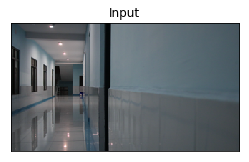

In [70]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
#import cv2

ind = 11
testPT = xtestT[ind]
print("Actual distance==="+str(ytestT[ind,1,0]*320))
testPT = testPT.view(1,3,180,320)
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
print("Pred distance==="+str(finalpred1.data[ind,0]*320))
testx = testPT.numpy()
testx = np.reshape(testx,(3,180,320))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(180,320,3))
#imshow(testx)
scipy.misc.imsave('test.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)



#print(finalpred.data[n,0]*(180/np.pi))
#print(ytestT[ind,0,0]*(180/np.pi))
print(ytestT[ind,1,0]-finalpred1.data[ind,0])